Names: Jessica Hatfield and Nate Ostrander

# Assessing Arrest Data at the University of Maryland

The purpose of this project is ...

In [1]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Data collection and processing

We are getting our data from the <a href="http://www.umpd.umd.edu/stats/arrest_report.cfm">University of Maryland Police Department's Crime Stats</a> website. We are using the arrest data for the past seven years, i.e. from 2010 to 2017, because the data from the years 2006 to 2009 is not available. To collect the data from the webpage, we are using the python requests and BeautifulSoup packages and storing the data in a Pandas DataFrame. It is also important to note that the UMPD updates their arrest data every day, so the data we use for 2017 will change as the semester progresses.

Below is an example of the UMPD arrest data from 2010 before we began cleaning and processing the data. As you can see, because the HTML table contains rowspans and colspans, information corresponding to each arrest record is spread out across two rows of the dataframe.

In [2]:
r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=2010')
text = r.text
soup = BeautifulSoup(text, 'html.parser')
table = soup.find('table')
df = pd.read_html(str(table), flavor='bs4')[0]
df.head()

,0,1,2,3,4,5
0,ARRESTNUMBER,ARRESTED DATE TIMECHARGE,UMPD CASE NUMBER,AGE,RACE,SEX
1,16001,11/09/10 23:30,2010-00000115,NaN,Black,Male
2,CDS: Possess Paraphernalia,NaN,NaN,NaN,NaN,NaN
3,16002,11/10/10 00:20,2010-00000126,NaN,Black,Male
4,"Theft: $1,000 to Under $10,000",NaN,NaN,NaN,NaN,NaN


Next, we need to clean up and process the data. The problems resulting from rowspans and colpans are solved by moving the decription from the second row of the corresponding arrest record's data into the first row and then removing the second row completely. Additionally, a year column is added to the dataframe for easy access to each year's data. After individual dataframes are created for each year from 2010 to 2017, they are concatenated together to form one large dataframe that contains the arrest data for every year from 2010 to 2017. Finally, the values from the date_time column are converted into python datetime objects.

In [3]:
frames = []

# Have to make separate requests for every year
for i in range(2010, 2018):

    # Putting the data into a dataframe
    r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=' + str(i))
    text = r.text
    soup = BeautifulSoup(text, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table), flavor='bs4')[0]
    
    df.drop(df.index[:1], inplace=True)
    df.columns = ['arrest_number', 'date_time', 'case_number', 'age', 'race', 'gender']
    df['description'] = ''
    df['year'] = 0
    
    # Fixing issues caused by the row and colspans
    for index in range(1, df.shape[0]):
        descr = df.get_value(index + 1, 'arrest_number')
        df.set_value(index, 'description', descr)
        df.set_value(index, 'year', i)
    
    # Removing every other row
    df = df.iloc[::2]
    
    # Adding current df to the list of dataframes
    frames.append(df)

# Combining individual dataframes
dataframe = pd.concat(frames)
dataframe.reset_index(inplace=True, drop=True)

# Changing everything in the date_time column to python datetime objects
for index, row in dataframe.iterrows():
    date = dataframe.get_value(index, 'date_time').split(' ')[0].split('/')
    time = dataframe.get_value(index, 'date_time').split(' ')[1].split(':')
    dt = datetime.datetime(int(date[2]) + 2000, int(date[0]), int(date[1]), int(time[0]), int(time[1]))
    dataframe.set_value(index, 'date_time', dt)

dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010


# Exploratory data analysis and visualization

Before declaring a hypothesis, we want to understand our data better by visualizing it. First, we will plot the number of arrests against different units of time, such as year, month, and day of the week.

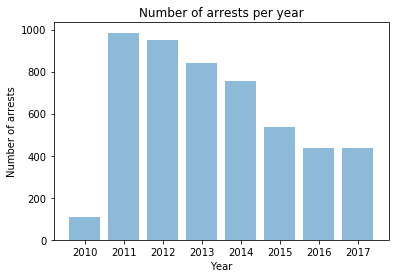

In [4]:
plt.close('all')

plt.title('Number of arrests per year')
plt.ylabel('Number of arrests')
plt.xlabel('Year')

num_arrests = []
for i in range(2010, 2018):
    num_arrests.append(len(dataframe.query('year == @i')))

plt.bar(range(2010, 2018), num_arrests, align='center', alpha=0.5)

plt.show()

With the exception of 2010, it seems clear from the plot above that the number of arrests at the University of Maryland has decreased since 2011. The discrepancy in 2010 could be due to faulty record keeping by the UMPD. Additionally, this plot could serve as a basis to the claim that crime has decreased at UMD over the past 6 years.

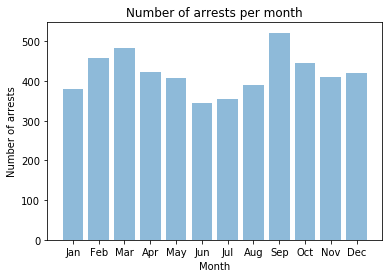

In [12]:
plt.close('all')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.title('Number of arrests per month')
plt.ylabel('Number of arrests')
plt.xlabel('Month')
plt.xticks(range(1,13), months)

num_arrests = [0]*12
for index, row in dataframe.iterrows():
    month = dataframe.get_value(index, 'date_time').month
    num_arrests[month - 1] += 1
    
plt.bar(range(1,13), num_arrests, align='center', alpha=0.5)

plt.show()

Because a majority of the students attending the University of Maryland are present on campus from September to May, the drop in number of arrests over the summer in this plot is unsuprising. What is interesting to note; however, is that the highest number of arrests occur in September. This could be due to the increased number of parties off-campus during syllabus week and the start of football tailgating season.

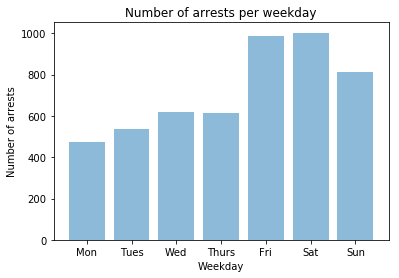

In [16]:
plt.close('all')

weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plt.title('Number of arrests per weekday')
plt.ylabel('Number of arrests')
plt.xlabel('Weekday')
plt.xticks(range(7), weekdays)

num_arrests = [0]*7
for index, row in dataframe.iterrows():
    weekday = dataframe.get_value(index, 'date_time').weekday()
    num_arrests[weekday] += 1
    
plt.bar(range(7), num_arrests, align='center', alpha=0.5)

plt.show()

As expected in a college town, the number of arrests at UMD are the highest on Fridays, Saturdays, and Sundays. This could be due to the fact that many college students go to bars or parties to drink on the weekends. However, it is important to note that this plot does not distinguish between types of arrests; therefore, it is unclear if most of the arrests on the weekends are alcohol related. 

# Analysis and hypothesis testing

Probably some stat and regression stuff here.

# Insight

Conclusions and things that we learned.